In [1]:
import rs_learn as rsl
import os
import joblib
from sklearn.feature_selection import VarianceThreshold 
import seaborn as sns
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from lightgbm import LGBMRegressor
import numpy as np


#==============================================================#
# rs_learn: A library for applying machine learning processes  #
# and artificial neural network in Remote Sensing              #
#==============================================================#

#=====================================================================#
# Author:      Reginald Jay L. Argamosa <regi.argamosa@gmail.com>     #  
# Affiliation: University of the Philippines -                        #
#              Training Center for Applied Geodesy and Photogrammetry #
#=====================================================================#



Using TensorFlow backend.


In [2]:
#get raster path, name, and file extension
#the raster file is DN
raster_path = r'C:\Users\Dlaniger\Projects\GuHEAT\REPORT_WRITING\images\sub'
raster_name = 'QC_BB_2019-02-05-L8'
raster_extension = 'tif'
rd = rsl.Raster_to_dataframe(raster_path = raster_path,
                                    raster_name = raster_name,
                                    raster_extension = raster_extension,
#                             no_data_value = -9999
                            )


        args: raster_path,
        raster_name,
        raster_extension
              
Opening C:\Users\Dlaniger\Projects\GuHEAT\REPORT_WRITING\images\sub\QC_BB_2019-02-05-L8.tif raster

Rows: 139
Cols: 187
Pixel size: 30.0
Number of bands: 12
Projection: PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]


In [3]:
#create a dataframe from raster
df_main = rd.make_df()

C:\Users\Dlaniger\Anaconda3\lib\site-packages\rs_learn\Raster_to_dataframe.py:139: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  self.df_to_use_idx = self.df_to_use.index.get_values()


In [4]:
df_main.shape

(25668, 12)

In [5]:
df_main.head(2)

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12
1,10422.0,9755.0,9046.0,8642.0,10292.0,11408.0,10657.0,9224.0,5025.0,31628.998047,27844.0,2720.0
2,10344.0,9594.0,8851.0,8485.0,9874.0,9919.0,8934.0,8288.0,5030.0,31564.000000,27794.0,2720.0


In [6]:
df_main.columns = ['COASTAL',
                   'BLUE',
                   'GREEN',
                   'RED',
                   'NIR',
                   'SWIR1',
                   'SWIR2',
                   'PAN',
                   'CIRR',
                   'TIRS1',
                   'TIRS2',
                   'BQA']

In [7]:
df_main.head(2)

,COASTAL,BLUE,GREEN,RED,NIR,SWIR1,SWIR2,PAN,CIRR,TIRS1,TIRS2,BQA
1,10422.0,9755.0,9046.0,8642.0,10292.0,11408.0,10657.0,9224.0,5025.0,31628.998047,27844.0,2720.0
2,10344.0,9594.0,8851.0,8485.0,9874.0,9919.0,8934.0,8288.0,5030.0,31564.000000,27794.0,2720.0


In [8]:
#convert OLI bands to reflectance
def to_reflectance(df, mp, ap):
    # MP*QCAL + AP
    df_reflectance = (mp * df) + ap
    return df_reflectance

df_reflectance = to_reflectance(df_main.iloc[:,1:-5],
              2.0000E-05,
              -0.100000)

In [9]:
# convert thermal bands to radiance (TIRS 1 only)
def to_radiance(df, ml, al):
    # ML*QCAL + AL
    df_radiance = (ml * df) + al
    return df_radiance
df_radiance = to_reflectance(df_main['TIRS1'],
              3.3420E-04,
              0.10000)

In [10]:
#merge the two df
df_oli_tirs = pd.concat([df_reflectance,
                        df_radiance],
                       axis = 1)
df_oli_tirs.head(2)

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2,TIRS1
1,0.09510,0.08092,0.07284,0.10584,0.12816,0.11314,10.670411
2,0.09188,0.07702,0.06970,0.09748,0.09838,0.07868,10.648689


In [11]:
# convert TIRS1 to brightness
df_oli_tirs['BT'] = (1321.0789 / np.log\
                     ((774.8853 / df_oli_tirs['TIRS1']) + 1)) \
                        - 273.15

In [12]:
#compute for the land surface temperature using brightness band
# Reference :Algorithm for Automated Mapping of Land Surface Temperature
# Using LANDSAT 8 Satellite Data 
# Author: Ugur Avdan and Gordana Jovanovska

# first, compute for ndvi and proportion of vegetation
df_oli_tirs['NDVI'] = (df_oli_tirs['NIR'] - df_oli_tirs['RED']) / \
                        (df_oli_tirs['NIR'] + df_oli_tirs['RED'])

df_oli_tirs['PV'] = np.square((df_oli_tirs['NDVI'] - 0.2) / (0.5 - 0.2))
#then, compute for the emissivity
df_oli_tirs['E'] = 1 #fill first with values

df_oli_tirs.loc[df_oli_tirs.NDVI < 0, 'E'] = 0.991 #emissivity for water

df_oli_tirs.loc[(df_oli_tirs.NDVI >= 0) & \
                (df_oli_tirs.NDVI < 0.2), 'E'] = 0.966 # land covered with soil

df_oli_tirs.loc[(df_oli_tirs.NDVI >= 0.2) & \
                (df_oli_tirs.NDVI < 0.5), 'E'] = \
                (((0.973 * df_oli_tirs['PV']) + \
                  (1 - df_oli_tirs['PV']) * 0.966) + 0.005) # mixtures of soil and
                                                            # vegetation cover
df_oli_tirs.loc[df_oli_tirs.NDVI >= 0.5, 'E'] = 0.973 # covered with vegetation

In [13]:
#finally, compute for the LST
df_oli_tirs['LST'] = (df_oli_tirs['BT'] / \
                      (1 + (10.895 * df_oli_tirs['BT'] * \
                            np.log(df_oli_tirs['E'])) / 14388))

In [14]:
df_oli_tirs.to_csv('main_df.csv',
                  index = False)

In [15]:
#select features and target
#pv,e,bt are not included since these were used for computing the target, LST
X_orig = df_oli_tirs[['BLUE', 
    'GREEN',
    'RED',
    'NIR',
    'SWIR1',
    'SWIR2',
    'NDVI',
    'PV']]
y = df_oli_tirs['LST']

In [16]:
# compute indices as new features
#vegetation indices
X_orig['DVI'] = X_orig['NIR'] - X_orig['RED']
X_orig['GCI'] = (X_orig['NIR'] / X_orig['GREEN']) - 1
X_orig['GDVI'] = (X_orig['NIR'] - X_orig['GREEN'])
X_orig['GLI'] = ((X_orig['GREEN'] - X_orig['RED']) + (X_orig['GREEN'] + X_orig['BLUE'])) / ((2* X_orig['GREEN']) + X_orig['RED'] + X_orig['BLUE'])
X_orig['GNDVI'] = (X_orig['NIR'] - X_orig['GREEN']) / (X_orig['NIR'] + X_orig['GREEN'])
X_orig['GRVI'] = (X_orig['NIR'] / X_orig['GREEN'])
X_orig['IPVI'] = X_orig['NIR'] / (X_orig['NIR'] + X_orig['RED'])
X_orig['MSR'] = ((X_orig['NIR'] / X_orig['RED']) -1) / (np.sqrt(X_orig['NIR'] / X_orig['RED']) + 1)
X_orig['NLI'] = (X_orig['NIR'] **2 - X_orig['RED']) / (X_orig['NIR'] **2 + X_orig['RED'])
X_orig['NDVI'] = (X_orig['NIR'] - X_orig['RED']) / (X_orig['NIR'] + X_orig['RED'])
X_orig['RDVI'] = (X_orig['NIR'] - X_orig['RED']) / np.sqrt((X_orig['NIR'] + X_orig['RED']))
X_orig['SR'] = X_orig['NIR'] / X_orig['RED']
X_orig['VARI'] = (X_orig['GREEN'] - X_orig['RED']) / (X_orig['GREEN'] + X_orig['RED'] - X_orig['BLUE'])
X_orig['SAVI'] = ((X_orig['NIR'] - X_orig['RED']) + 1.5) / (X_orig['NIR'] + X_orig['RED'] + 1)

# bulit up indices
X_orig['VNIR-BI'] = (X_orig['RED'] - X_orig['NIR']) / (X_orig['RED'] + X_orig['NIR'])
X_orig['NDBI'] = (X_orig['SWIR1'] - X_orig['NIR']) / (X_orig['SWIR1'] + X_orig['NIR'])
X_orig['UI'] = (X_orig['SWIR2'] - X_orig['NIR']) /(X_orig['SWIR2'] + X_orig['NIR']) 
X_orig['DBSI'] = ((X_orig['SWIR1'] - X_orig['GREEN']) / (X_orig['SWIR1'] + X_orig['GREEN'])) - X_orig['NDVI']
X_orig['BU'] = X_orig['NDBI'] - X_orig['NDVI']
                                                           
#others
X_orig['NDWI'] = (X_orig['NIR'] - X_orig['SWIR1']) /\
                        (X_orig['NIR'] + X_orig['SWIR1']) 
X_orig['MNDWI'] = (X_orig['GREEN'] - X_orig['NIR']) /\
                        (X_orig['GREEN'] + X_orig['NIR']) 
# bulit up indix BAEM
X_orig['BAEM'] = X_orig['NDBI'] - X_orig['NDVI'] - X_orig['MNDWI']

df_X = X_orig

C:\Users\Dlaniger\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dlaniger\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Dlaniger\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [17]:
cols_orig = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'PV', 'DVI',
       'GCI', 'GDVI', 'GLI', 'GNDVI', 'GRVI', 'IPVI', 'MSR', 'NLI', 'RDVI',
       'SR', 'VARI', 'SAVI', 'VNIR-BI', 'NDBI', 'UI', 'DBSI', 'BU', 'NDWI',
       'MNDWI', 'BAEM']

In [17]:
# for i in df_X.columns:
#     rd.df_to_raster(df_X[i],
#                    i,
#                    'reg')

In [18]:
# engineer more feat
#basic stat
df_X['AVE'] = np.mean(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1) 
df_X['MIN'] = np.min(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['MAX'] = np.max(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['STD'] = np.std(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['VAR'] = np.var(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['PTP'] = np.ptp(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['SKEW'] = skew(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)
df_X['KUR'] = kurtosis(MinMaxScaler().fit_transform(df_X[cols_orig]), 
                       axis = 1)

#percentile
df_X['P10'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 10, axis = 1)
df_X['P20'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 20, axis = 1)
df_X['P30'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 30, axis = 1)
df_X['P40'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 40, axis = 1)
df_X['P50'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 50, axis = 1)
df_X['P60'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 60, axis = 1)
df_X['P70'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 70, axis = 1)
df_X['P80'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 80, axis = 1)
df_X['P90'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 90, axis = 1)
df_X['P99'] = np.percentile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 99, axis = 1)

#quantile
df_X['Q10'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.1, axis = 1)
df_X['Q20'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.2, axis = 1)
df_X['Q30'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.3, axis = 1)
df_X['Q40'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.4, axis = 1)
df_X['Q50'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.5, axis = 1)
df_X['Q60'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.6, axis = 1)
df_X['Q70'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.7, axis = 1)
df_X['Q80'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.8, axis = 1)
df_X['Q90'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.9, axis = 1)
df_X['Q99'] = np.quantile(MinMaxScaler().fit_transform(df_X[cols_orig]),
                            q = 0.99, axis = 1)

In [19]:
df_X

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2,NDVI,PV,DVI,GCI,...,Q10,Q20,Q30,Q40,Q50,Q60,Q70,Q80,Q90,Q99
1,0.09510,0.08092,0.07284,0.10584,0.12816,0.11314,0.184688,0.002605,0.03300,0.307958,...,0.154756,0.166694,0.208341,0.247508,0.276259,0.424868,0.504372,0.616470,0.660472,0.742557
2,0.09188,0.07702,0.06970,0.09748,0.09838,0.07868,0.166168,0.012718,0.02778,0.265645,...,0.139873,0.151204,0.190626,0.215384,0.258922,0.453570,0.507455,0.564987,0.607061,0.726106
3,0.09058,0.07202,0.06496,0.08936,0.11238,0.10382,0.158113,0.019495,0.02440,0.240766,...,0.133267,0.135449,0.192445,0.219268,0.248940,0.429981,0.506864,0.633630,0.680858,0.776823
4,0.10030,0.08884,0.08356,0.11464,0.11190,0.08900,0.156811,0.020725,0.03108,0.290410,...,0.166413,0.192517,0.197010,0.240969,0.269288,0.452721,0.509013,0.552198,0.588619,0.684627
5,0.09944,0.09458,0.08502,0.10918,0.10326,0.08292,0.124408,0.063491,0.02416,0.154367,...,0.148576,0.171179,0.194013,0.215181,0.254842,0.427958,0.501137,0.541791,0.580450,0.685367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25849,0.08848,0.07202,0.06862,0.08828,0.10996,0.09108,0.125303,0.061996,0.01966,0.225771,...,0.123224,0.141200,0.187109,0.205790,0.236680,0.409089,0.505902,0.610525,0.687322,0.755740
25850,0.08916,0.07058,0.07356,0.09024,0.11464,0.09508,0.101832,0.107078,0.01668,0.278549,...,0.119501,0.148220,0.193126,0.213050,0.247104,0.391491,0.486868,0.626182,0.725444,0.747718
25851,0.09356,0.07718,0.07972,0.09566,0.12370,0.10438,0.090888,0.132282,0.01594,0.239440,...,0.122521,0.167579,0.185550,0.219117,0.267284,0.382438,0.488566,0.635177,0.725810,0.751670
25852,0.09598,0.08122,0.08582,0.10706,0.12676,0.10558,0.110120,0.089760,0.02124,0.318148,...,0.141382,0.178518,0.200797,0.237471,0.266822,0.404052,0.463467,0.607961,0.699460,0.715236


In [20]:
df_X.shape

(25668, 57)

In [21]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_X, 
                                                    y, 
                                                    test_size = 0.33, 
                                                    random_state = 1)
df_train = pd.concat([X_train,
                     y_train],
                    axis = 1)
df_train.to_csv('df_train.csv', index = False)

df_test = pd.concat([X_test,
                     y_test],
                    axis = 1)
df_test.to_csv('df_test.csv', index = False)


In [22]:
X_train.shape

(17197, 57)

In [23]:
X_test.shape

(8471, 57)

In [24]:
X_train.columns

Index(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'PV', 'DVI',
       'GCI', 'GDVI', 'GLI', 'GNDVI', 'GRVI', 'IPVI', 'MSR', 'NLI', 'RDVI',
       'SR', 'VARI', 'SAVI', 'VNIR-BI', 'NDBI', 'UI', 'DBSI', 'BU', 'NDWI',
       'MNDWI', 'BAEM', 'AVE', 'MIN', 'MAX', 'STD', 'VAR', 'PTP', 'SKEW',
       'KUR', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90',
       'P99', 'Q10', 'Q20', 'Q30', 'Q40', 'Q50', 'Q60', 'Q70', 'Q80', 'Q90',
       'Q99'],
      dtype='object')

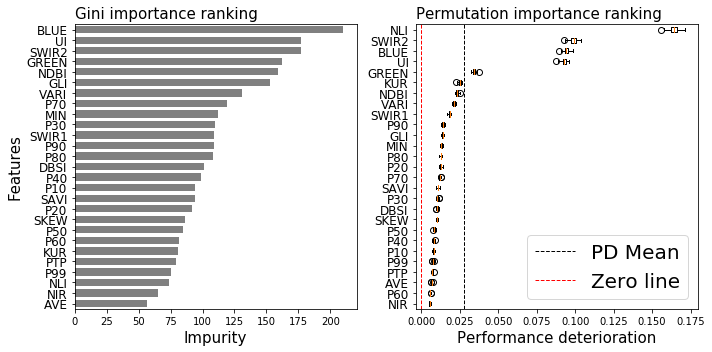

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Score using important features: [1.133012737705064, 1.122856416088426, 1.1513155937973472, 1.1559957171437159, 1.1509642470217087, 1.0907795622133507, 1.14563862347552, 1.1207701034276734, 1.129620330346056, 1.1127995245619409]
Average scores of 10 folds 1.1313752855780803
Number of original features: 57
Number of selected features: 27
Important features selected: ['NIR', 'P60', 'AVE', 'PTP', 'P99', 'P10', 'P40', 'P50', 'SKEW', 'DBSI', 'P30', 'SAVI', 'P70', 'P20', 'P80', 'MIN', 'GLI', 'P90', 'SWIR1', 'VARI', 'NDBI', 'KUR', 'GREEN', 'UI', 'BLUE', 'SWIR2', 'NLI']


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished


In [25]:
#auto select important features and its values using gradient descent

# std_train = pd.DataFrame(StandardScaler().fit_transform(X_train), 
#                           columns = X_train.columns).set_index(X_train.index)

# std_test = pd.DataFrame(StandardScaler().fit_transform(X_test), 
#                           columns = X_test.columns).set_index(X_test.index)

imp_feat, df_feature_imp = rsl.select_features_gd(
                                        X_train,
                                        y_train,
                                        'lst_train',
                                        model = LGBMRegressor(n_estimators = 100),
                                        figsize = (10, 5),
                                        legendsize = 20, 
                                        fontsize_ticks = 12,
                                        scoring = 'neg_root_mean_squared_error' 
                                        )

In [26]:
#check for variance
norm_data = pd.DataFrame(MinMaxScaler().fit_transform(X_train[imp_feat]),
                         columns = imp_feat)
var_thresh = VarianceThreshold(threshold = 0.01)  
transformed_data = var_thresh.fit_transform(norm_data) 

In [27]:
final_feat = norm_data[norm_data.columns[var_thresh.get_support(indices=True)]].columns
final_feat

Index(['NIR', 'AVE', 'PTP', 'P99', 'P10', 'P40', 'P50', 'DBSI', 'P30', 'P20',
       'P80', 'MIN', 'GLI', 'P90', 'NDBI', 'KUR', 'UI', 'NLI'],
      dtype='object')

In [28]:
model = LGBMRegressor(n_estimators = 100)
pipeline = Pipeline([('sc', 
              StandardScaler()),
            ('mod',
             model)])

kf = KFold(n_splits = 10, 
           shuffle = True) 

scores_fold = cross_val_score(pipeline, 
                              X_train[final_feat], 
                              y_train, 
                              cv = kf,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 1)
print(f'Score using important features: {[-1 * i for i in scores_fold]}')
print(f'Average scores of 10 folds {-1 * mean(scores_fold)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Score using important features: [1.1095040868641914, 1.1256304110733573, 1.1413497980117153, 1.148927789682208, 1.1618116027298833, 1.1414439868479411, 1.1454121221449034, 1.1655918290544247, 1.1348418757030776, 1.0987445076119347]
Average scores of 10 folds 1.1373258009723637


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


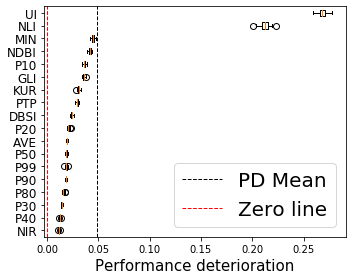

In [29]:
model = LGBMRegressor(n_estimators = 100)

pipeline = Pipeline([('sc', 
              StandardScaler()),
            ('mod',
             model)])

model_imp = pipeline.fit(X_train[final_feat], 
                      y_train)

#Plot feature importance
feature_importance = permutation_importance(model_imp, 
                                            X_train[final_feat], 
                                            y_train, 
                                            n_repeats = 100,
                            random_state = 0)    


perm_sorted_idx = feature_importance.importances_mean.argsort()


tree_importance_sorted_idx = np.argsort(model_imp.named_steps['mod'].feature_importances_)


tree_indices = np.arange(0, len(model_imp.named_steps['mod'].feature_importances_)) + 0.5

labels = X_train[final_feat].columns[perm_sorted_idx]

f, ax = plt.subplots(figsize = (5,4))

ax.boxplot(feature_importance.importances[perm_sorted_idx].T, 
            vert = False,
        labels = labels)
ax.set_yticklabels(X_train[final_feat].columns[perm_sorted_idx],
                    fontsize = 12)

df_imp = pd.DataFrame(feature_importance.importances[perm_sorted_idx])
df_imp['sum_imp'] = df_imp.sum(axis = 1)
df_imp['features'] = X_train[final_feat].columns[perm_sorted_idx]
df_imp['mean'] = df_imp.iloc[:,:-2].mean(axis = 1)
feat_mean = df_imp['mean'].mean(axis = 0)

ax.axvline(feat_mean , 
    color = 'k', 
    linestyle = '--', 
    linewidth = 1,
    label = 'PD Mean')

ax.axvline(0, 
    color = 'r', 
    linestyle = '--', 
    linewidth = 1,
    label = 'Zero line')

ax.legend(fontsize = 20,
         loc = 'lower right')
    
ax.set_xlabel('Performance deterioration',
       fontsize = 15)

f.tight_layout()

graph_output_path = os.path.join(os.getcwd(), 
                  'output_rs_learn',
                  'graphs')

if not os.path.exists(graph_output_path):
    os.makedirs(graph_output_path)
    
f.savefig(os.path.join(graph_output_path,
            f'final_var_imp.png'),
           dpi = 300)    
plt.show()

In [30]:
labels

Index(['NIR', 'P40', 'P30', 'P80', 'P90', 'P99', 'P50', 'AVE', 'P20', 'DBSI',
       'PTP', 'KUR', 'GLI', 'P10', 'NDBI', 'MIN', 'NLI', 'UI'],
      dtype='object')

In [171]:
# #rasterize final feat

# for i in final_feat:
#     rd.df_to_raster(df_X[i],
#                    i,
#                    'reg')


In [135]:
# #output LST 100m
# rd.df_to_raster(df_oli_tirs['LST'],
#                'LST_100m',
#                'reg')